In [3]:
import sys
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

%matplotlib inline
import load_nmeg as ld
import transform_nmeg as tr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipdb as ipdb

sns.set_style("white")

af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = '/home/greg/current/NMEG_miscellany/figures/multiyear_figs/'

In [4]:
# Years to load
start = 2007
end = 2014
# Sites to load
sites = [ 'Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm' ]

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }
    

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt


ValueError: invalid literal for int() with base 10: '1.'

## Remove Mixed Conifer data after the fire

In [66]:
hourly[ 'Vcm' ] = hourly[ 'Vcm' ][ hourly[ 'Vcm' ].index < dt.datetime( 2013, 5, 3) ]
print(hourly[ 'Vcm' ].index)

DatetimeIndex(['2007-01-01 00:30:00', '2007-01-01 01:00:00',
               '2007-01-01 01:30:00', '2007-01-01 02:00:00',
               '2007-01-01 02:30:00', '2007-01-01 03:00:00',
               '2007-01-01 03:30:00', '2007-01-01 04:00:00',
               '2007-01-01 04:30:00', '2007-01-01 05:00:00', 
               ...
               '2013-05-02 19:00:00', '2013-05-02 19:30:00',
               '2013-05-02 20:00:00', '2013-05-02 20:30:00',
               '2013-05-02 21:00:00', '2013-05-02 21:30:00',
               '2013-05-02 22:00:00', '2013-05-02 22:30:00',
               '2013-05-02 23:00:00', '2013-05-02 23:30:00'],
              dtype='datetime64[ns]', length=111071, freq='30T', tz=None)


## Resample to daily frequency

In [67]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F' ], 
                                precip_col='P_F' , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)

In [68]:
# Daily files to Dan so we are working on the same data
d.Seg.to_csv('processed_data/US-Seg_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Ses.to_csv('processed_data/US-Ses_daily.csv', na_rep=-9999, date_format='%Y%m%d')
#d.Sen.to_csv('processed_data/US-Sen_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Wjs.to_csv('processed_data/US-Wjs_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Mpj.to_csv('processed_data/US-Mpj_daily.csv', na_rep=-9999, date_format='%Y%m%d')
#d.Mpg.to_csv('processed_data/US-Mpg_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Vcp.to_csv('processed_data/US-Vcp_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Vcm.to_csv('processed_data/US-Vcm_daily.csv', na_rep=-9999, date_format='%Y%m%d')

## Set some plotting parameters

In [69]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

gcolour= [0.9, 0.5, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];

nmeg_palette = [gcolour, scolour, jcolour, pjcolour, pcolour, mcolour]
nmeg_names = ['Grassland', 'Shrubland', 'Juniper Sav.', 
              'Pinyon-Juniper', 'Ponderosa Pine', 'Mixed Conifer']

## Plotting definitions

In [70]:
# Plot definition for a 6x1 plot of timeseries
def plot_tseries( dict_in, varname, texty, fighandle, ylab,
                            xlims=[ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )],
                            ylims=None, sitelist=sites,
                            sitenames=nmeg_names, colors=nmeg_palette):
    ax = list();
    for i, site in enumerate(sitelist):
        # Pull out x and y axes
        idx = dict_in[site].index
        if type(dict_in[site]) is pd.Series:
            var = dict_in[site]
        else:
            var = dict_in[site][varname]
            
        ax.append(fighandle.add_subplot(6, 1, i+1))
        plt.plot( xlims, [0, 0], ':k')
        if len(var.shape) == 2:
            plt.plot( idx, var[varname[0]], color=colors[i], lw=1.25 )
            plt.plot( idx, -var[varname[1]], color=colors[i], lw=1.25, alpha=0.5 )
        else:
            plt.plot( idx, var, color=colors[i], lw=1.25 )
        if ylims:
            plt.ylim( ylims )
            
        plt.xlim( xlims )
        plt.text( dt.datetime( 2007, 2, 1 ), texty, sitenames[i], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        if i < 5:
            plt.setp( ax[i].get_xticklabels(), visible=False)
    
    for i in (0, 2, 4):
        ax[i].set_ylabel(ylab, fontsize=14)
    
    plt.setp( ax[5].get_xticklabels(), fontsize=14 )
    return ax


# Plot definition for one-site axis showing Multiyear mean + individual years in background
def plot_multiyr_lines( ax_in, clim, meancolor, 
                      syr=start, eyr=end,
                      indyrs=False, hilite=[None] ):
    # If requested, plot individual years
    if indyrs: 
        for i in range( syr, eyr+1 ):
            # If requested, highlight a particular year in red
            if i in hilite:
                hicolour='Red'
            else:
                hicolour=[0.7, 0.7, 0.7]
            # Plot the individual year line (mean + anomaly)
            ax_in.plot(clim.index, 
                       clim.allyr_mean + clim[ str(i) + '_anom' ], 
                       color=hicolour, lw=0.5)
    
    ax_in.plot(clim.index, clim.predrght_mean, color=meancolor)
    ax_in.plot(clim.index, clim.predrght_mean + clim.allyr_stderr, color=meancolor, alpha=.4)
    ax_in.plot(clim.index, clim.predrght_mean - clim.allyr_stderr, color=meancolor, alpha=.4)
    
# Plot definition for a 3 x 2 plot of multiyear mean fluxes
def plot_multiyr_mean_sites( clim_in, varname, texty, fighandle, ind_yrs=False,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmeg_names, colors=nmeg_palette, hilite_yr=None ):
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
        
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(3, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plot_multiyr_lines( ax[i], clim[site], colors[i], hilite=hilite_yr, indyrs=ind_yrs )
        if type(clim_in) is list:
            plot_multiyr_lines( ax[i], -clim2[site], colors[i], hilite=hilite_yr, indyrs=ind_yrs )
            
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[i], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < 4:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel('Mean ' + varname + '\n$g\ C\ m^2$', fontsize=14)

## Plot NEE timeseries

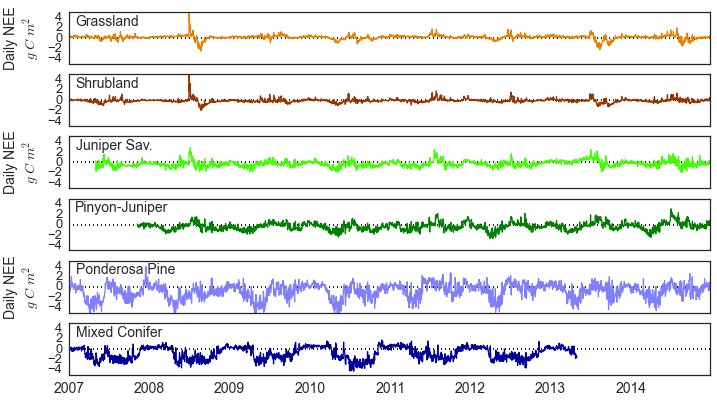

In [71]:
ylims = [ -5, 5 ]

fig1 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_tseries( d, 'FC_F_g_int', 2.5, fig1, 'Daily NEE\n$g\ C\ m^2$', ylims=ylims)

#plt.show()
fig1.savefig( fig_path + 'NMEG_daily_FC.svg')
fig1.savefig( fig_path + 'NMEG_daily_FC.tiff', dpi=200)

## Plot partitioned timeseries

* GPP is negative

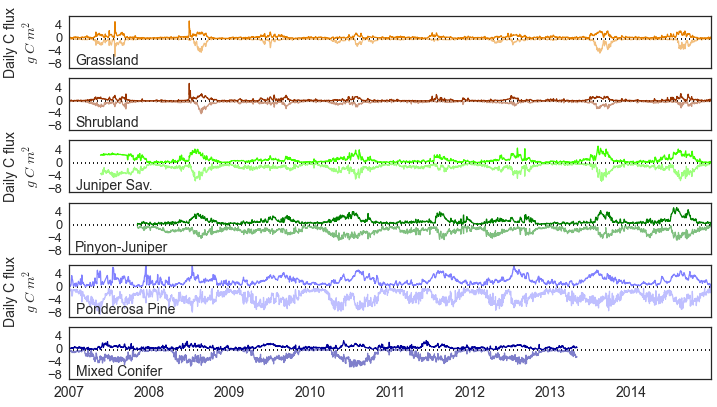

In [72]:
ylims = [ -9, 7 ]

fig2 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_tseries( d, ['RECO_g_int', 'GPP_g_int'], -8, fig2, 'Daily C flux\n$g\ C\ m^2$', ylims=ylims)
for j in range(0,6):
    ax[j].yaxis.set_ticks(np.arange(-8, 6, 4))

#plt.show()
fig2.savefig( fig_path + 'NMEG_daily_part.svg')
fig2.savefig( fig_path + 'NMEG_daily_part.tiff', dpi=200)


## Calculate multi-year means and anomaly

In [104]:
# Get climatologies
import math
def get_climatology( ser ):
    # Create dataframes to hold raw year data and climatology calculations
    raw_years = pd.DataFrame( index = range( 1, 367 ))
    climatology = raw_years.copy()
    # Put 1 day values for each year in a column
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        raw_years[ str(i) ] = np.nan
        raw_years[ str(i) ][ 0:len(year_vals)] = year_vals
    # Get summary stats each day of the year
    climatology[ 'allyr_mean' ] = raw_years.mean(axis=1)
    climatology[ 'allyr_stdev' ] = raw_years.std(axis=1)
    climatology[ 'allyr_stderr' ] = climatology.allyr_stdev / math.sqrt( len(np.unique(ser.index.year))-1 )
    climatology[ 'predrght_mean' ] = raw_years[['2007', '2008', '2009', '2010']].mean(axis=1)
    climatology[ 'drght_mean' ] = raw_years[['2011', '2012']].mean(axis=1)
    climatology[ 'postdrght_mean' ] = raw_years[['2013', '2014']].mean(axis=1)
    # Calculate anomalies from allyear mean for drought-post-drought
    climatology[ 'predrght_mean_anom' ] = climatology.predrght_mean - climatology.allyr_mean
    climatology[ 'drght_mean_anom' ] = climatology.drght_mean - climatology.allyr_mean
    climatology[ 'postdrght_mean_anom' ] = climatology.postdrght_mean - climatology.allyr_mean

    # Calculate the anomaly of the original series
    # (subtract multiyear mean)
    anom = ser.copy()
    anom_norm = ser.copy()
    for i in np.unique(ser.index.year):
        # column for each year
        climatology[ str(i) ] = raw_years[ str(i )]
        climatology[ str(i) + '_anom' ] = raw_years[ str(i )] - climatology.allyr_mean
        climatology[ str(i) + '_preanom' ] = raw_years[ str(i )] - climatology.predrght_mean
        # entire timeseries
        anom[ anom.index.year==i ] = ser[ ser.index.year==i ] - climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values
        anom_norm[ anom_norm.index.year==i ] = ((ser[ ser.index.year==i ] - 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values) / 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values)
    
    return anom, anom_norm, climatology

## For FC, GPP, RECO, VPD, P

In [105]:
# Mean NEE, GPP, REC), PRECIP, VPD and anomalies
# Create dictionaries for each
fc_anom, fc_anom_n, fc_clim = dict(), dict(), dict()
gpp_anom, gpp_anom_n,  gpp_clim = dict(), dict(), dict()
re_anom, re_anom_n,  re_clim = dict(), dict(), dict()
p_anom, p_anom_n,  p_clim = dict(), dict(), dict()
vpd_anom, vpd_anom_n,  vpd_clim = dict(), dict(), dict()
# Loop through sites, calculate climatology and fill dictionaries
for site in sites:
    fc_anom[ site ], fc_anom_n[ site ], fc_clim[ site ] = get_climatology( d[ site ]['FC_F_g_int' ] )
    gpp_anom[ site ], gpp_anom_n[ site ], gpp_clim[ site ] = get_climatology( d[ site ][ 'GPP_g_int' ] )
    re_anom[ site ], re_anom_n[ site ], re_clim[ site ] = get_climatology( d[ site ][ 'RECO_g_int' ] )
    p_anom[ site ], p_anom_n[ site ], p_clim[ site ] = get_climatology( d[ site ][ 'P_F' ] )
    vpd_anom[ site ], vpd_anom_n[ site ], vpd_clim[ site ] = get_climatology( d[ site ][ 'VPD_F' ] )

## Plot multiyear C flux means

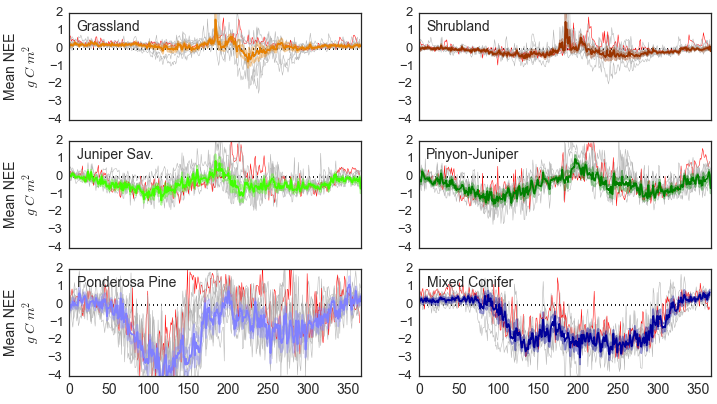

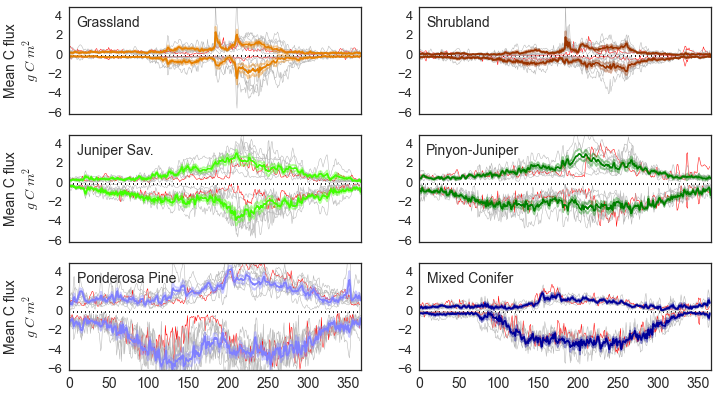

In [106]:
# Plot NEE
ylims = [ -4, 2 ]
xlims = [ 0, 366 ]
highlight_year = [2011]
fig3 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'NEE', 1, fig3, ind_yrs=True,
                        ylims=ylims, hilite_yr=highlight_year)     
fig3.savefig( fig_path + 'NMEG_mean_NEE.svg')
fig3.savefig( fig_path + 'NMEG_mean_NEE.tiff', dpi=200)

# Plot GPP
#ylims = [ 0, 6 ]

#fig4 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
#plot_multiyr_mean_sites( gpp_clim, 'GPP', 5, fig4, 
#                        ylims=ylims, hilite_yr=highlight_year)   
#fig4.savefig( fig_path + 'NMEG_mean_GPP.svg')
#fig4.savefig( fig_path + 'NMEG_mean_GPP.tiff', dpi=200)

# Plot RECO
#ylims = [ 0, 5 ]
#fig5 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
#plot_multiyr_mean_sites( re_clim, 'RECO', 4, fig5, 
#                        ylims=ylims, hilite_yr=highlight_year)
#fig5.savefig( fig_path + 'NMEG_mean_RECO.svg')
#fig5.savefig( fig_path + 'NMEG_mean_RECO.tiff', dpi=200)

# Plot RECO and GPP
ylims = [ -6, 5 ]
fig6 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'C flux', 3, fig6,
                        ylims=ylims, ind_yrs=True, hilite_yr=highlight_year)
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.svg')
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.tiff', dpi=200)

#plt.show()

## Limit to growing season

The next several plots are limited to growing season only.

In [109]:
startseas = 90
endseas = 300

## Plot mean daily values for all drought periods

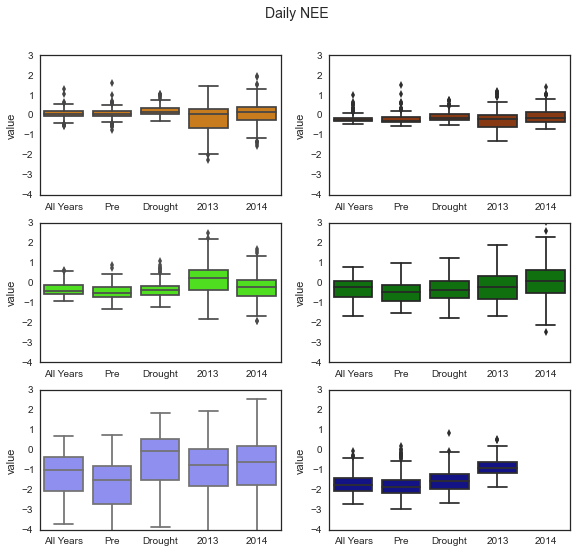

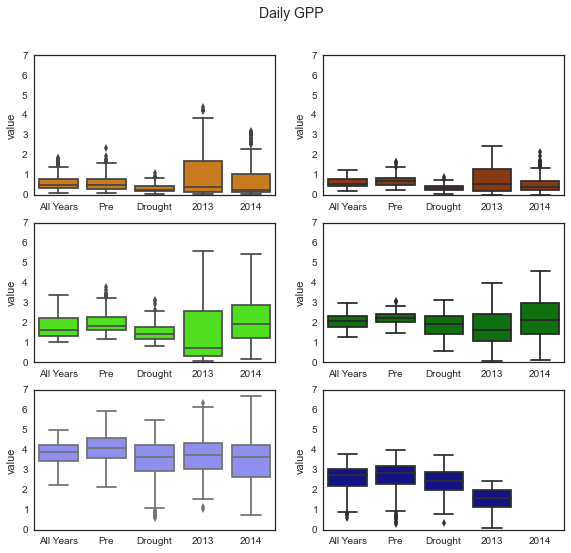

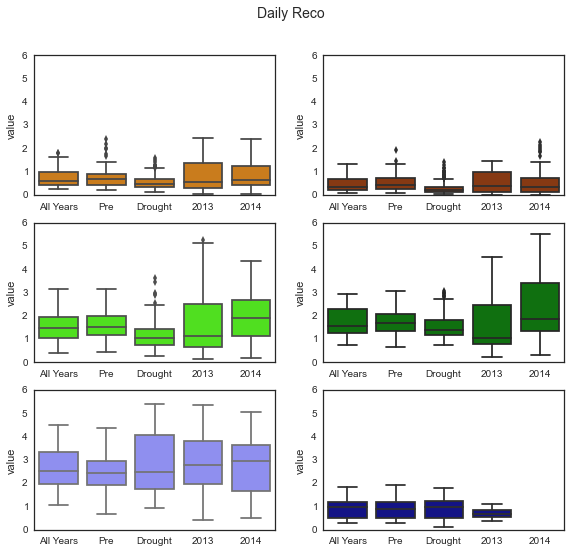

In [117]:
def plot_drought_dist( clim, fig, y_limit, anom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        if anom:
            #subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
            #                       'postdrght_mean_anom']])
            subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
                                   '2013_anom', '2014_anom']])
            xlabels = ['Pre', 'Drought', '2013', '2014']
            
        else:
            #subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
            #                       'postdrght_mean']])
            subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
                                   '2013', '2014']])
            xlabels = ['All Years', 'Pre', 'Drought', '2013', '2014']
        
        ax = fig.add_subplot(3, 2, i+1)    
        sns.boxplot(x='variable', y='value', data=subset, color=nmeg_palette[i])
        ax.set_xlabel('')
        #ax.set_xticklabels(['Pre', 'Drought', 'Post'])
        ax.set_xticklabels(xlabels)
        ax.set_ylim(y_limit)

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-4, 3])
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [0, 7])
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [0, 6])
plt.suptitle('Daily Reco', size=14)

## Anomalies w/ respect to all year mean

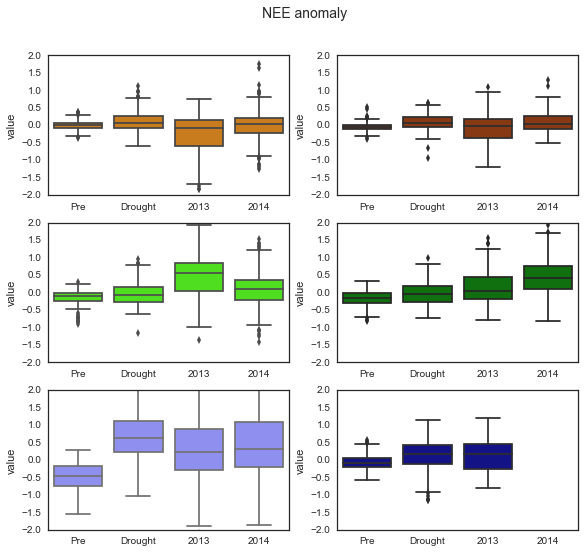

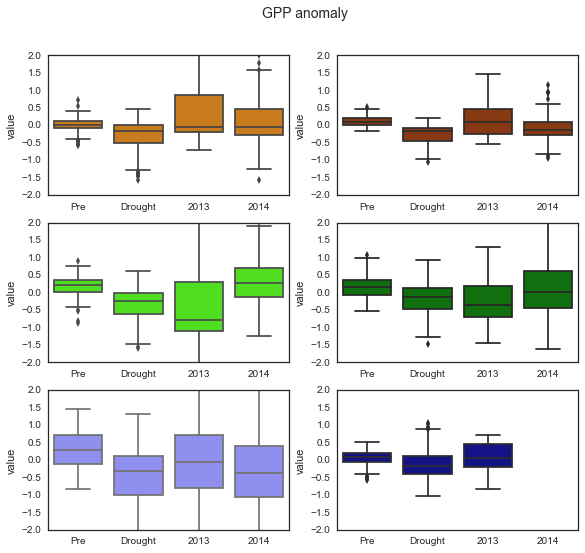

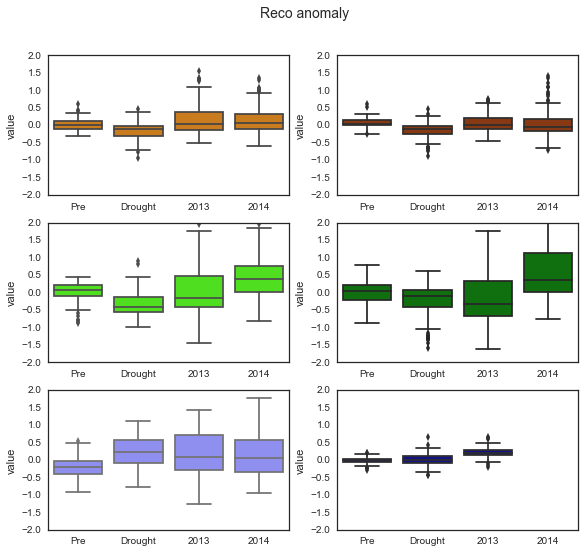

In [118]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], anom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily flux values

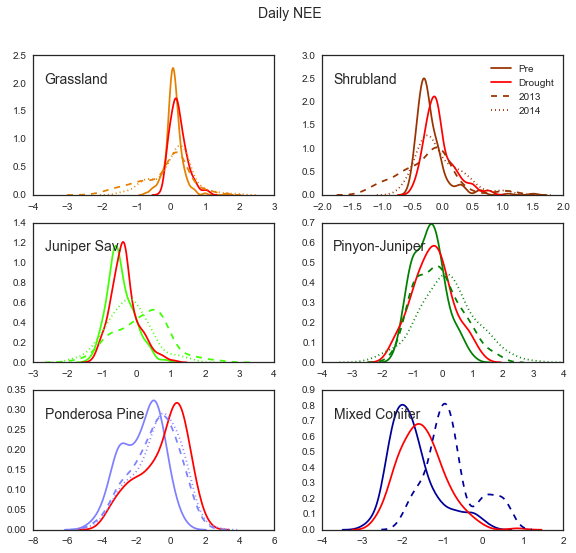

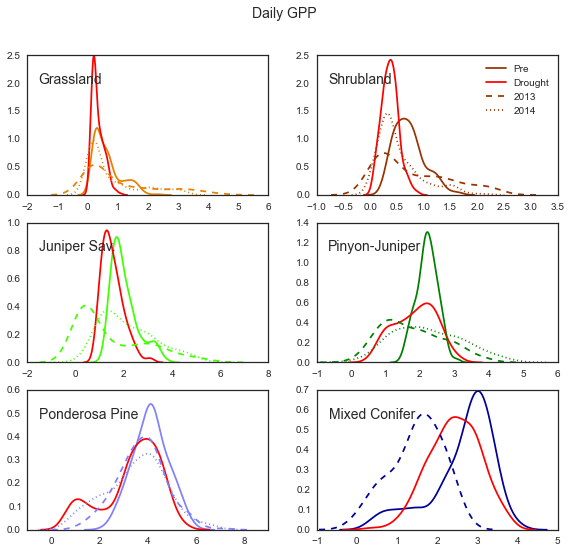

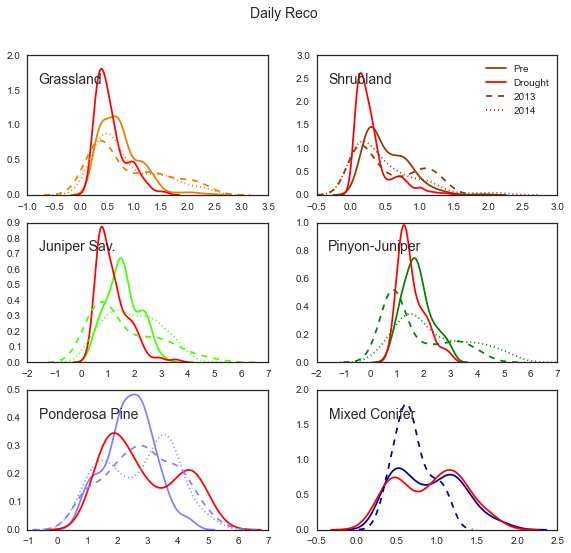

In [116]:
def plot_drought_kde( clim, fig, anom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        ax = fig.add_subplot(3, 2, i+1)
        if anom:
            ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean_anom','drght_mean_anom','2013_anom','2014_anom']
        else:
            #ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean','drght_mean','2013','2014']
        sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmeg_palette[i])
        sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
        sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmeg_palette[i], ls='--')
        if site!='Vcm':
            sns.kdeplot(data[kde_vars[3]].dropna(), legend=False, color=nmeg_palette[i], ls=':')
        plt.text( .05, .8, nmeg_names[i], size=14, transform=ax.transAxes  )
        ax.set_xlabel('')
        if i==1:
            #plt.legend(['Pre', 'Post', 'Drought'])
            plt.legend(['Pre', 'Drought', '2013', '2014'])
        
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX)
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY)
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ)
plt.suptitle('Daily Reco', size=14)

## Histograms/KDEs of daily anomaly values

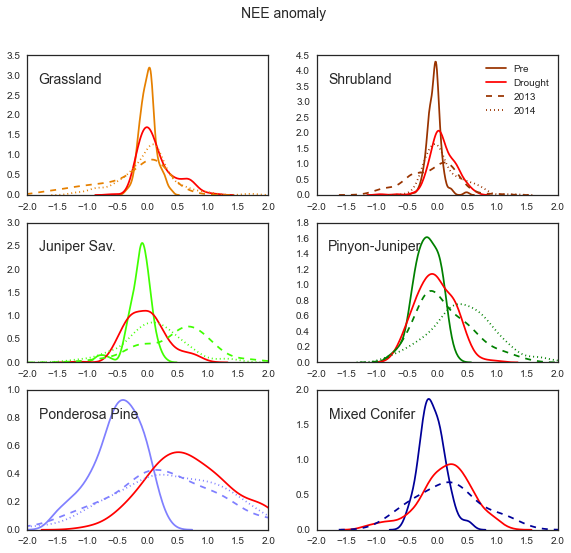

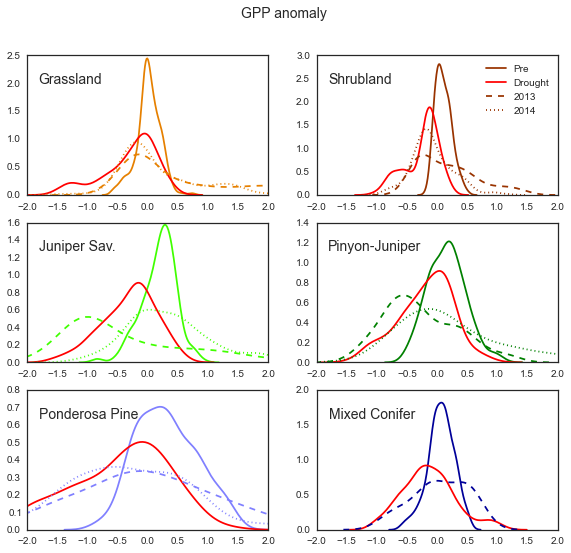

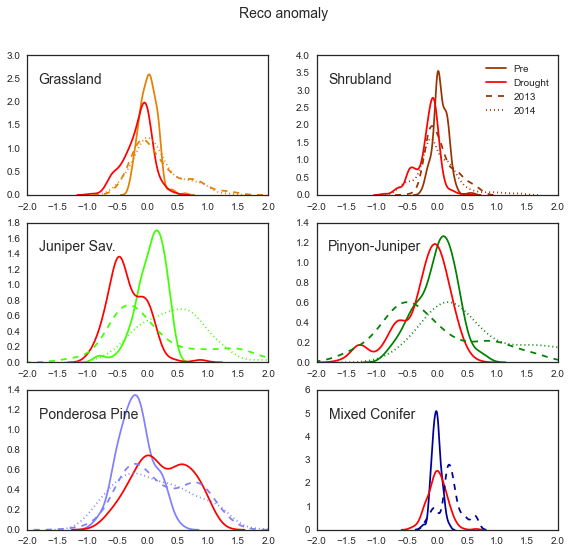

In [102]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, anom=True)
plt.suptitle('Reco anomaly', size=14)

## Cumulative sums by year

These show cumulative C flux (NEE or GPP) for each year measured.

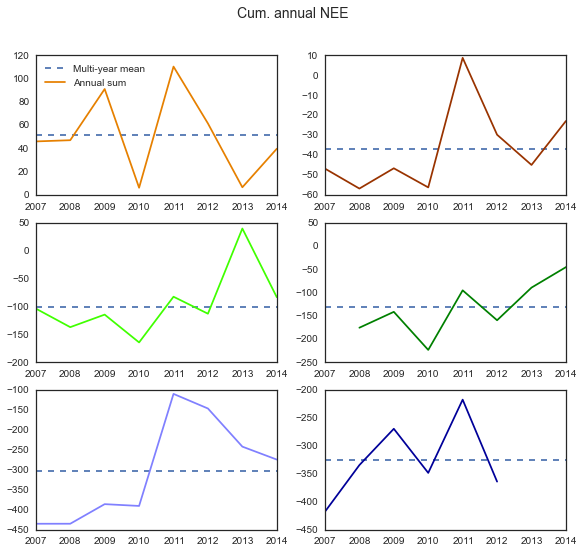

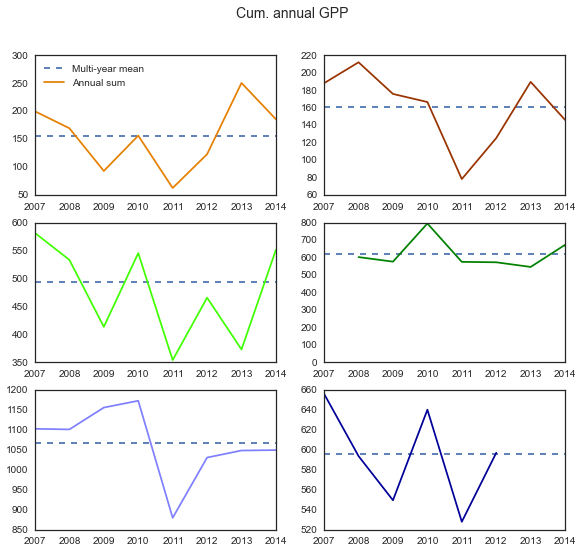

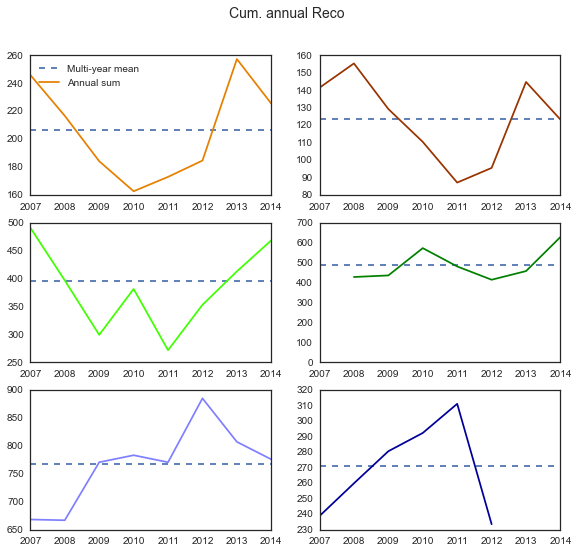

In [123]:
def plot_cumulative_annual( daily_var, clim, fig ):
    for i, site in enumerate(sites):
        ax = fig.add_subplot(3, 2, i+1)
        data = d[site][ daily_var ].groupby(d[site].index.year).sum()
        mean = clim[site].allyr_mean.sum()
        plt.plot([data.index[0], data.index[-1]], [mean, mean], ls='--')
        if site == 'Vcm':
            data = data[data.index < 2013]
        elif site == 'Mpj':
            data = data[data.index > 2007]  
        else:
            data = data[data.index < 2015]
        plt.plot(data.index, data, color=nmeg_palette[i])
        
        if i == 0:
            plt.legend(['Multi-year mean', 'Annual sum'], loc='upper left')
        plt.xlim([2007, 2014])
        x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        ax.xaxis.set_major_formatter(x_formatter)
        #print(data.GPP_g_int.sum())

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'FC_F_g_int', fc_clim, figX )
plt.suptitle('Cum. annual NEE', size=14)

figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'GPP_g_int', gpp_clim, figY )
plt.suptitle('Cum. annual GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'RECO_g_int', re_clim, figZ )
plt.suptitle('Cum. annual Reco', size=14)


## Table of cumulative values

* Summed g C/m2 during the different periods we are interested in (pre-, post-, drought, and all year means)
* Differences between pre-drought/potential cumulative values and and drought/post-drought periods
* Percentage of pre-drought and potential cumulative flux


In [124]:
indices = ['AllYr Mean', 'Pre','Drought', 'Post', 'Potential', 
           'Pre-Drought', 'Drought % of pre', 'Pre-Post','Post % of pre',
           'Pot.-Drought', 'Drought % of pot.', 'Pot.-Post', 'Post % of pot.']
nee_t = pd.DataFrame(columns=sites, index = indices)
gpp_t = pd.DataFrame(columns=sites, index = indices)
reco_t = pd.DataFrame(columns=sites, index = indices)

for i, site in enumerate(sites):
        
    # Sum up the climatology columns for the site
    sums = fc_clim[site].sum()
    nee_t[site].loc['AllYr Mean'] = sums.allyr_mean
    nee_t[site].loc['Pre'] = sums.predrght_mean
    nee_t[site].loc['Drought'] = sums.drght_mean
    nee_t[site].loc['Post'] = sums.postdrght_mean
    nee_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    nee_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    nee_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    nee_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = gpp_clim[site].sum()
    gpp_t[site].loc['AllYr Mean'] = sums.allyr_mean
    gpp_t[site].loc['Pre'] = sums.predrght_mean
    gpp_t[site].loc['Drought'] = sums.drght_mean
    gpp_t[site].loc['Post'] = sums.postdrght_mean
    gpp_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    gpp_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    gpp_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    gpp_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = re_clim[site].sum()
    reco_t[site].loc['AllYr Mean'] = sums.allyr_mean
    reco_t[site].loc['Pre'] = sums.predrght_mean
    reco_t[site].loc['Drought'] = sums.drght_mean
    reco_t[site].loc['Post'] = sums.postdrght_mean
    reco_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    reco_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    reco_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    reco_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
nee_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,51.20145,-37.01659,-99.91102,-131.6528,-301.3499,-325.0544
Pre,47.75203,-51.68872,-145.0231,-175.042,-410.9897,-341.8203
Drought,86.08364,-10.46362,-97.33448,-126.9479,-126.8557,-289.9347
Post,23.20753,-33.8915,-21.58721,-67.162,-257.5641,-11.57211
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,-38.3316,-41.2251,-47.68859,-48.09412,-284.134,-51.88563
Drought % of pre,180.2722,20.24353,67.11655,72.52424,30.86592,84.82079
Pre-Post,24.54451,-17.79722,-123.4359,-107.88,-153.4256,-330.2482
Post % of pre,48.60008,65.56847,14.88536,38.36908,62.66925,3.385436
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
gpp_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,155.202,160.4372,494.3363,619.5483,1068.509,596.0694
Pre,154.8026,185.8869,559.6299,653.7678,1134.425,610.3402
Drought,92.88775,101.7905,410.0969,575.3743,955.8478,562.7101
Post,218.2556,167.9215,462.5552,610.8948,1049.451,78.71243
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,61.91484,84.09642,149.533,78.39344,178.5767,47.63008
Drought % of pre,0.60004,0.5475936,0.7328002,0.8800898,0.8425838,0.9219614
Pre-Post,-63.45299,17.96542,97.07467,42.873,84.97344,531.6278
Post % of pre,1.409896,0.903353,0.8265377,0.9344217,0.9250956,0.1289649
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
reco_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,206.4041,123.4207,394.9997,487.8955,767.1594,271.0198
Pre,202.556,134.1984,415.1197,478.7258,723.4349,268.5282
Drought,178.9714,91.32685,312.7624,448.4265,828.9921,272.7754
Post,241.4631,134.03,440.968,543.7328,791.887,67.14032
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,23.58457,42.8715,102.3573,30.29932,-105.5572,-4.247239
Drought % of pre,0.8835652,0.6805363,0.7534271,0.9367084,1.145911,1.015817
Pre-Post,-38.90715,0.168387,-25.84829,-65.007,-68.45212,201.3879
Post % of pre,1.192081,0.9987452,1.062267,1.135792,1.094621,0.2500308
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Post-During Drought calculations

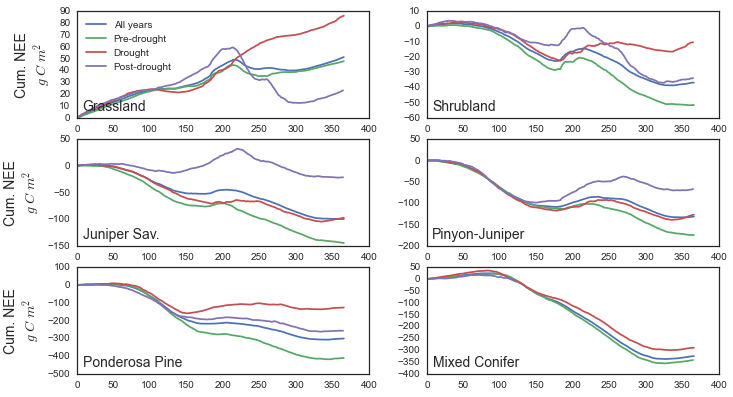

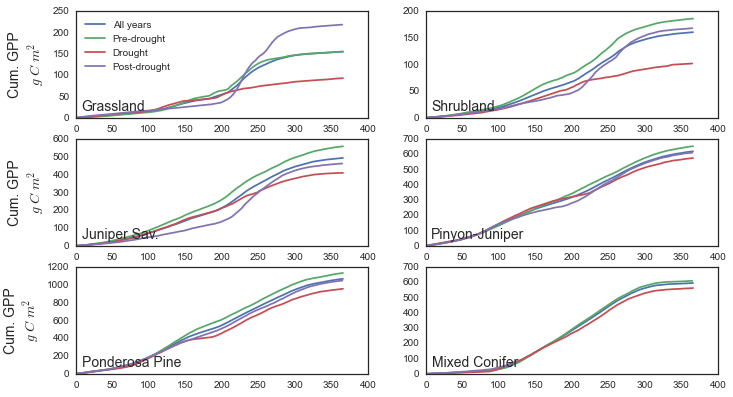

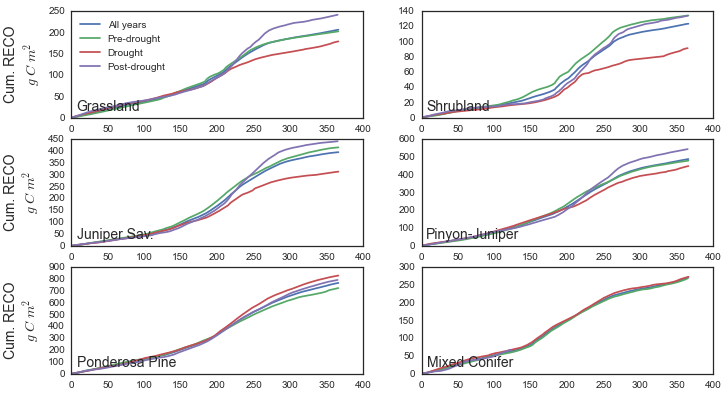

In [125]:
def plot_cumulative_drought( clim, fig, label ):
    ax = list();
    for i, site in enumerate(sites):
        ax.append(fig.add_subplot(3, 2, i+1))
        plt.plot( clim[site].index,  np.cumsum(clim[site].allyr_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].predrght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].drght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].postdrght_mean))
            
        #plt.xlim( xlims )
        plt.text( .02, .07, nmeg_names[i], size=14, transform=ax[i].transAxes )
        if i==0:
            plt.legend(['All years', 'Pre-drought', 'Drought','Post-drought'], 'upper left')

    for i in (0, 2, 4):
            ax[i].set_ylabel('Cum. {0}\n$g\ C\ m^2$'.format(label), fontsize=14)
            
figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( fc_clim, figX, 'NEE' )

figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( gpp_clim, figY, 'GPP' )

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( re_clim, figZ, 'RECO' )

## Plot monthly mean anomalies

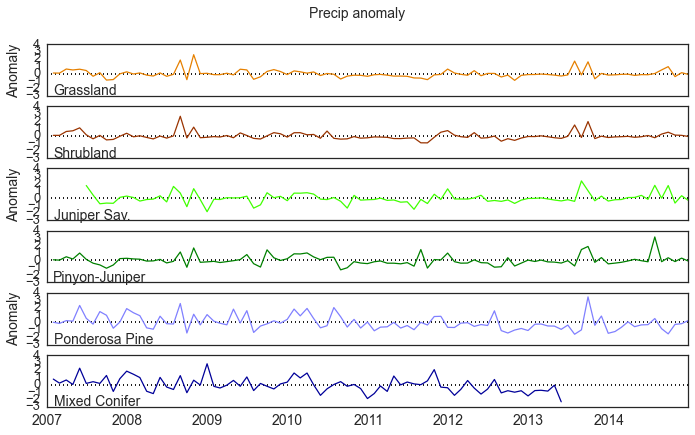

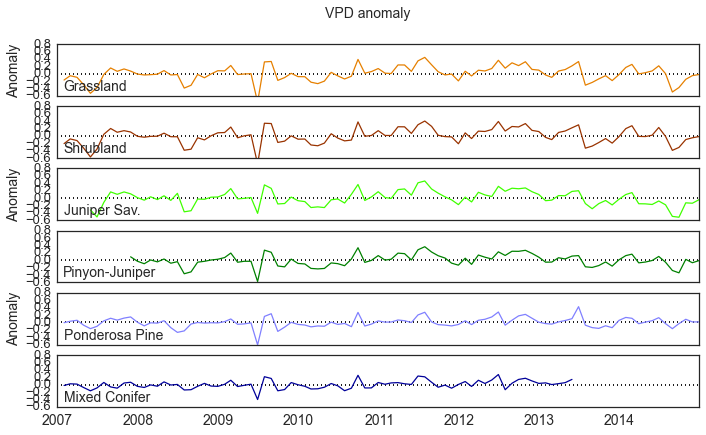

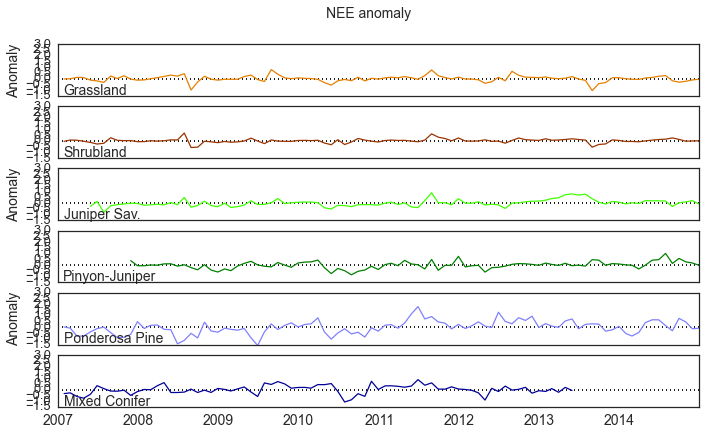

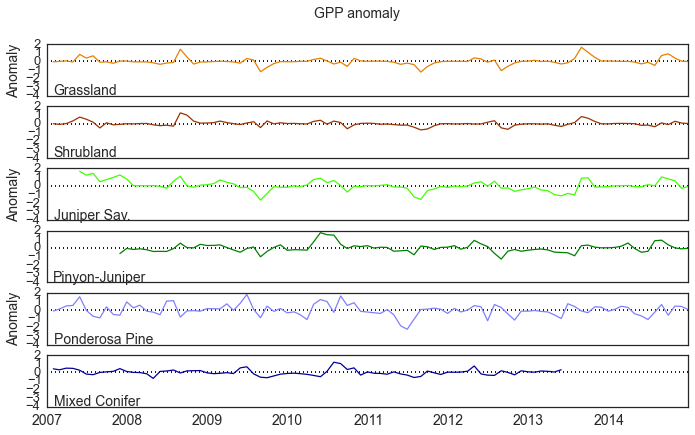

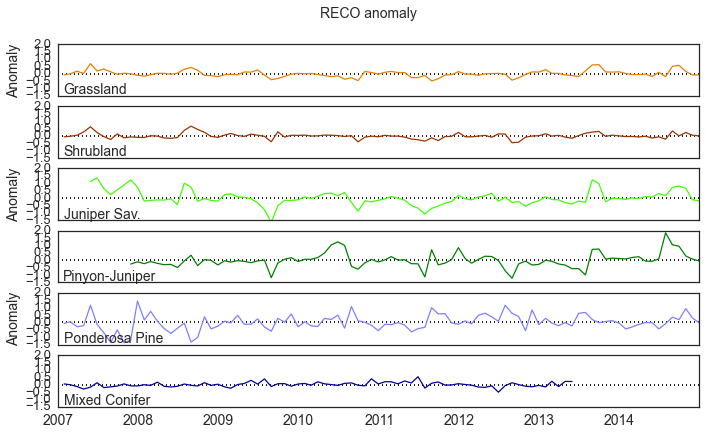

In [82]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['P_F','VPD_F','NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['Precip anomaly', 'VPD anomaly', 'NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-3, 4],[-0.6,0.8],[-1.5,3],[-4,2],[-1.5,2]]

for i, anom in enumerate([p_anom, vpd_anom, fc_anom, gpp_anom, re_anom]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)


## Plot monthly mean normalized C flux anomaly

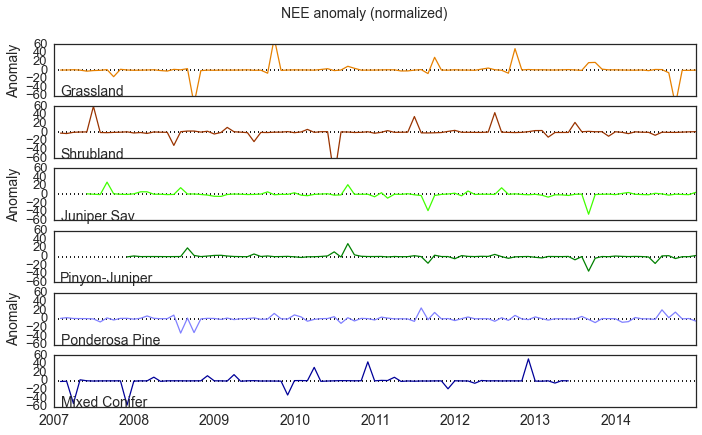

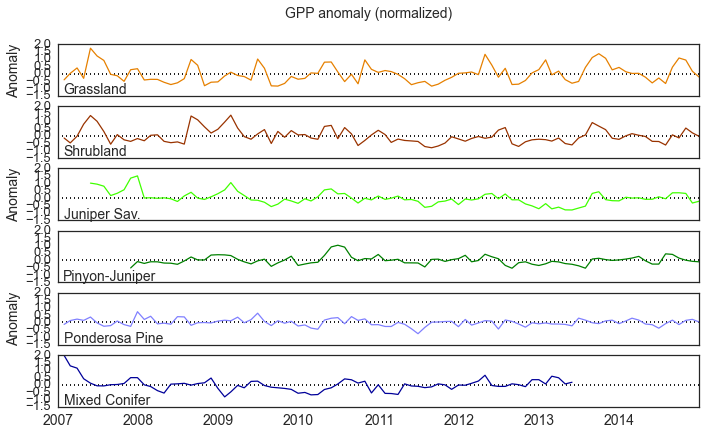

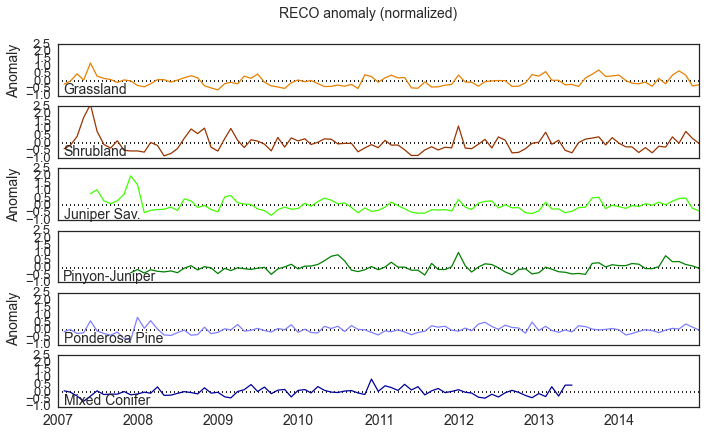

In [83]:
varlist = ['NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-60,60],[-1.5,2],[-1,2.5]]

for i, anom in enumerate([fc_anom_n, gpp_anom_n, re_anom_n]):
    
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i] + ' (normalized)', size=14)
    


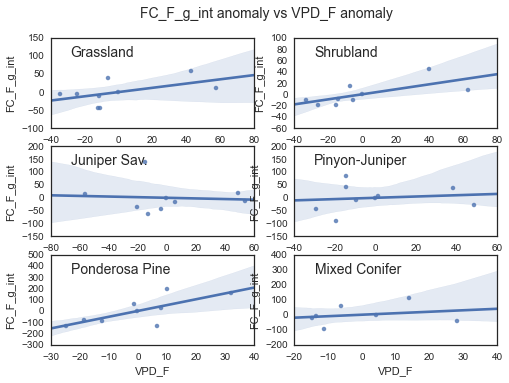

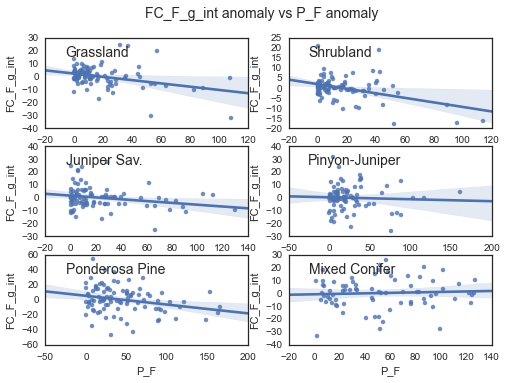

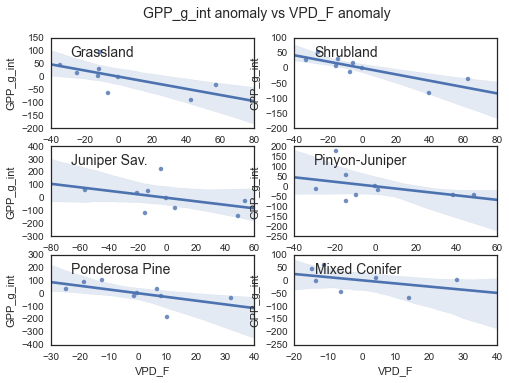

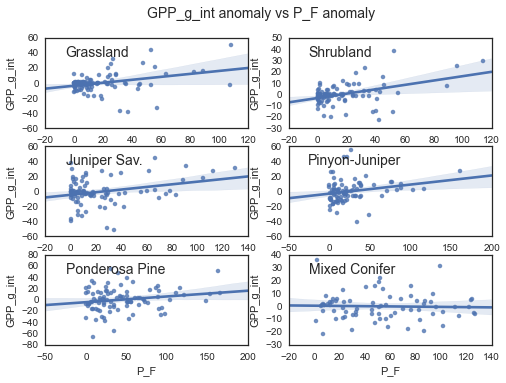

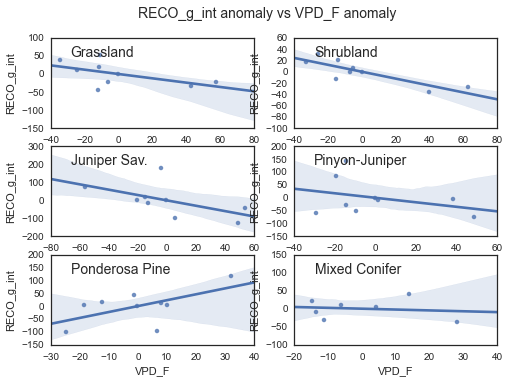

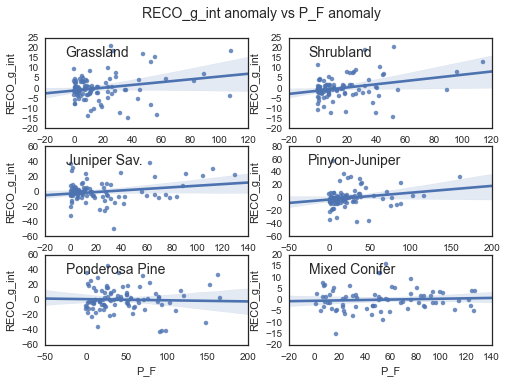

In [84]:
texty = 20
figX = plt.figure()

x_anoms = [vpd_anom, p_anom]
x_labels = ['VPD_F', 'P_F']
y_anoms = [fc_anom, gpp_anom, re_anom]
y_labels = [ 'FC_F_g_int', 'GPP_g_int', 'RECO_g_int']

for i in range(0, 3):
    figA = plt.figure()
    x_anom = x_anoms[0]
    y_anom = y_anoms[i]
    
    for j, site in enumerate(sites):
        x_y_anom = x_anom[ site ].resample('A',how='sum')
        y_y_anom = y_anom[ site ].resample('A',how='sum')
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figA.add_subplot(3, 2, j+1)
        sns.regplot(x_labels[0], y_labels[i], df)
        plt.text( .1, .8, nmeg_names[j], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[0] + ' anomaly', size=14)
    
    figB = plt.figure()
    x_anom = x_anoms[1]
    
    
    for k, site in enumerate(sites):
        # Yearly summed precip
        x_y_anom = d[ site ].P_F.resample('M',how='sum')
        # Yearly summed precip anomaly
        #x_y_anom = x_anom[ site ].resample('M',how='sum')
        y_y_anom = y_anom[ site ].resample('M',how='sum')
        y_y_anom = y_y_anom.shift(-1)
        
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figB.add_subplot(3, 2, k+1)
        sns.regplot(x_labels[1], y_labels[i], df)
        plt.text( .1, .8, nmeg_names[k], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[1] + ' anomaly', size=14)


## Plot whatever

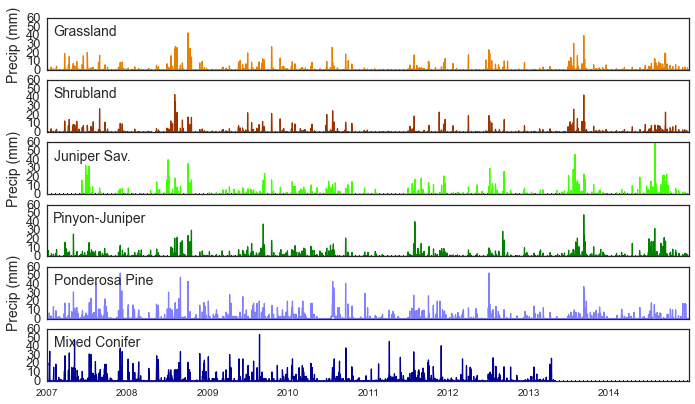

In [66]:
varname = 'P_F'
label = 'Precip (mm)'
ylims = [ 0, 60 ]
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]
site_yloc = 40

figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = list();
for i, site in enumerate(sites):
    ax.append(figX.add_subplot(6, 1, i+1))
    plt.plot( xlims, [0, 0], ':k')
    plt.plot( d[ site ].index, d[ site ][ varname ], 
             color=nmeg_palette[i], lw=1.25)
    plt.ylim( ylims )
    plt.xlim( xlims )
    plt.text( dt.datetime( 2007, 2, 1 ), site_yloc, nmeg_names[i], size=14  )
    #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
    plt.setp( ax[i].get_yticklabels(), fontsize=13)
    if i < 5:
        plt.setp( ax[i].get_xticklabels(), visible=False)
for i in (0, 2, 4):
    ax[i].set_ylabel(label, fontsize=14)
    
#plt.setp( ax[5].get_xticklabels(), fontsize=14 )
    
#plt.show()

figX.savefig( fig_path + 'NMEG_daily_PRECIP.tiff', dpi=200)